# Congress

The National Congress of Brazil is the legislative body of Brazil's federal government. The Congress is bicameral, composed of the Federal Senate (the upper house) and the Chamber of Deputies (the lower house). 

|![Brazilian congress building.](src_images/congress_building.jpg)|
|:--:|
| *Brazilian congress building.* |

The Senate represents the 26 states and the Federal District. Each state and the Federal District has a representation of three Senators, who are elected by popular ballot for a term of eight years. Every four years, renewal of either one third or two-thirds of the Senate takes place.

The Chamber of Deputies represents the people of each state, and its members are elected for a four-year term by a system of proportional representation. Seats are allotted proportionally according to each state's population, with each state eligible for a minimum of 8 seats (least populous) and a maximum of 70 seats (most populous). Unlike the Senate, the whole of the Chamber of Deputies is renewed every four years.

We can use *Mixed Integer Programming* to discover how many of the 513 seats in the Chamber of Deputies each state gets in the election. It's also of our interest to compare it with a allocation without the artifitial bounds of 8 (minimum) and 70 (maximum) seats.

We will mainly use the Python MIP library, but some auxiliary functions will be necessary.

In [1]:
from mip import *

import re
import numpy as np
import pandas as pd
from pandas_ods_reader import read_ods
import matplotlib.pyplot as plt
from pylab import rcParams

Using Python-MIP package version 1.6.7


Our population data comes from IBGE (Brazilian Institute of Geography and Statistics). It is a *ods* file, which can be open using pandas 0.25.1. We can then rapidly treat it for our intended format.

In [2]:
xls = pd.ExcelFile('Data/estimativa_dou_2019.ods', engine="odf")

In [3]:
pop = pd.read_excel(xls, 0, header=1).loc[1:32][["BRASIL E UNIDADES DA FEDERAÇÃO", "POPULAÇÃO ESTIMADA"]]
pop.columns = ["Division", "Population"]
pop = pop[~pop.Division.str.contains('Região')]
pop["Population"] = pop["Population"].apply(lambda x: int(re.sub(r'\([^)]*\)', '', str(x)).replace(".","")))
pop["Region"] = ["North"]*7 + ["Northeast"]*9 + ["Southeast"]*4 + ["South"]*3 + ["Central-West"]*4
pop = pop.sort_values(by=["Division"])

We have the division's (state or federal district) name, its population and the region it belongs.

In [4]:
pop

,Division,Population,Region
3,Acre,881935,North
16,Alagoas,3337357,Northeast
7,Amapá,845731,North
4,Amazonas,4144597,North
18,Bahia,14873064,Northeast
12,Ceará,9132078,Northeast
32,Distrito Federal,3015268,Central-West
21,Espírito Santo,4018650,Southeast
31,Goiás,7018354,Central-West
10,Maranhão,7075181,Northeast


We can calculate the fraction of seats each state should have by population.

In [5]:
number_of_divisions = len(pop)
number_of_representatives = 513

reg = pop.iloc[:,2].values

c = pop.iloc[:,1].values
c = number_of_representatives * c / c.sum()
c

array([  2.15293288,   8.14697865,   2.0645536 ,  10.11757006,
        36.30733388,  22.29274378,   7.36071209,   9.81011494,
        17.13283302,  17.27155607,   8.50609333,   6.78391302,
        51.67612825,  27.91196854,   9.80883822,  21.00085711,
        23.33021412,   7.9904279 ,   8.56074328,  27.77351157,
        42.14626186,   4.33846728,   1.47875158,  17.49029992,
         5.61145458, 112.09514352,   3.83959694])

Now, let's start our model. We want to minimize the absolute difference between the seats allocation and the fractions above.

<b>x</b> (integer, with bounds) represents our allocation and <b>y</b> (real) the absolute difference. We then need 3 types of constrains:

1. The sum of our allocation needs to be the total ammount of seats;
1. If <b>a</b>'s population is smaller then <b>b</b>'s then <b>a</b> should not have more seats than <b>b</b>;
1. The absolute value should be greater or equal of both the positive and negative value.

In [6]:
def set_model(lb=1, ub=number_of_representatives):
    m = Model()
    x = [m.add_var(var_type=INTEGER, lb=lb, ub=ub, name=pop.iloc[i,0]) for i in range(number_of_divisions)]
    y = [m.add_var(name="abs diff " + pop.iloc[i,0]) for i in range(number_of_divisions)]

    m += xsum(x) == number_of_representatives

    for i in range(number_of_divisions):
        for j in range(i+1, number_of_divisions):
            if(c[i] < c[j]):
                m += x[i] <= x[j]
            else:
                m += x[i] >= x[j]

    for i in range(number_of_divisions):
        m += x[i] - c[i] <= y[i]
        m += c[i] - x[i] <= y[i]

    m.objective = xsum(y)
    
    return m

The next function optimizes the model, printing wether or not it was successful.

In [7]:
def solve(m, verbose=True):
    m.max_gap = 0.01
    status = m.optimize(max_seconds=300)
    if verbose:
        if status == OptimizationStatus.OPTIMAL:
            print('optimal solution cost {} found'.format(m.objective_value))
        elif status == OptimizationStatus.FEASIBLE:
            print('sol.cost {} found, best possible: {}'.format(m.objective_value, m.objective_bound))
        elif status == OptimizationStatus.NO_SOLUTION_FOUND:
            print('no feasible solution found, lower bound is: {}'.format(m.objective_bound))
    return m

For the sake of clarity, a formatting function.

In [8]:
def results(m):
    comparison = list()
    for i in range(number_of_divisions):
        comparison.append([m.vars[i].name, reg[i], m.vars[i].x, m.vars[i].x - c[i]])
    comparison.sort(key=lambda x: x[3], reverse=True)
    comparison = pd.DataFrame(comparison)
    comparison.columns = ["Division", "Region", "Representatives", "Difference"]
    return comparison

|![Brazilian congress interior.](src_images/congress_interior.jpg)|
|:--:|
| *Brazilian congress interior.* |

Firstly, let's se how would the allocation be without the artifitial bounds.

In [9]:
m1 = set_model()
m1 = solve(m1, False)
r1 = results(m1)
r1

,Division,Region,Representatives,Difference
0,Santa Catarina,South,18,0.509700
1,Mato Grosso,Central-West,9,0.493907
2,Rio Grande do Norte,Northeast,9,0.439257
3,Sergipe,Northeast,6,0.388545
4,Minas Gerais,Southeast,52,0.323872
5,Rio Grande do Sul,South,28,0.226488
6,Mato Grosso do Sul,Central-West,7,0.216087
7,Paraíba,Northeast,10,0.191162
8,Espírito Santo,Southeast,10,0.189885
9,Tocantins,North,4,0.160403


And now with the bounds.

In [10]:
m2 = set_model(8, 70)
m2 = solve(m2, False)
r2 = results(m2)
r2

,Division,Region,Representatives,Difference
0,Roraima,North,8,6.521248
1,Amapá,North,8,5.935446
2,Acre,North,8,5.847067
3,Tocantins,North,8,4.160403
4,Rondônia,North,8,3.661533
5,Sergipe,Northeast,8,2.388545
6,Bahia,Northeast,38,1.692666
7,Mato Grosso do Sul,Central-West,8,1.216087
8,Piauí,Northeast,9,1.009572
9,Pará,North,22,0.999143


The 5 states with the largest seat gains are all from the North region, while São Paulo state (from Southeast region) loses 42 seats (8.2% of all seats!!). Actually, the North region (small population per state) has almost 30 more seats because of the bounds.

In [11]:
gr1 = r1[["Region", "Representatives"]].groupby(["Region"]).sum()
gr2 = r2[["Region", "Representatives"]].groupby(["Region"]).sum()
gr1.columns = ["Unbounded"]
gr1["Bounded"] = gr2["Representatives"]
gr1 = gr1.T
gr1

Region,Central-West,North,Northeast,South,Southeast
Unbounded,40,44,139,74,216
Bounded,43,73,148,74,175


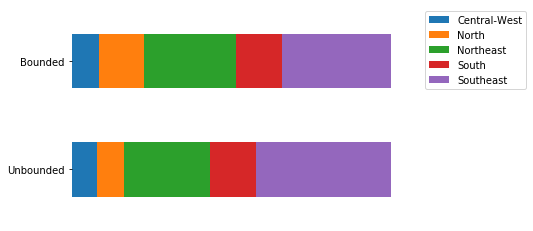

In [12]:
gr1.plot(kind='barh', stacked=True)

for spine in plt.gca().spines.values():
    spine.set_visible(False)

rcParams['figure.figsize'] = 7, 5
    
plt.tick_params(axis='x', which='both', bottom=False, top=False,labelbottom=False) 
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()